# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 14            
model_seed = 4           

# --- Training configuration ---
epochs = 3000            

# --- Dataset configuration ---
base_data_size = 60      
dataset_type = "data"   
dataset_quantities = [0, 600-60, 2000 - 60, 6000 - 60, 20000 - 60, 60000 - 60]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import MNIST_model_data as model_module

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    device = device
)

# MNIST specific initialization parameters
hidden_dims = [256, 128]

# Grab model
model_template = model_module.get_model(hidden_dims=hidden_dims, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.SGD(
        model.parameters(),
        lr=1e-2,         # usually requires higher LR than AdamW
        momentum=0.9,    # typical value, helps convergence
        weight_decay=1e-4  # optional, acts like L2 regularization
    )
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/3000: Train Loss 2.2896 | Test Loss 2.3031 | accs Train 0.1167 Test 0.0706


Epoch 100/3000: Train Loss 0.0093 | Test Loss 1.0421 | accs Train 1.0000 Test 0.6687


Epoch 200/3000: Train Loss 0.0034 | Test Loss 1.0775 | accs Train 1.0000 Test 0.6726


Epoch 300/3000: Train Loss 0.0021 | Test Loss 1.1001 | accs Train 1.0000 Test 0.6740


Epoch 400/3000: Train Loss 0.0015 | Test Loss 1.1172 | accs Train 1.0000 Test 0.6746


Epoch 500/3000: Train Loss 0.0011 | Test Loss 1.1308 | accs Train 1.0000 Test 0.6746


Epoch 600/3000: Train Loss 0.0009 | Test Loss 1.1421 | accs Train 1.0000 Test 0.6755


Epoch 700/3000: Train Loss 0.0008 | Test Loss 1.1516 | accs Train 1.0000 Test 0.6760


Epoch 800/3000: Train Loss 0.0007 | Test Loss 1.1598 | accs Train 1.0000 Test 0.6762


Epoch 900/3000: Train Loss 0.0006 | Test Loss 1.1670 | accs Train 1.0000 Test 0.6760


Epoch 1000/3000: Train Loss 0.0005 | Test Loss 1.1734 | accs Train 1.0000 Test 0.6760


Epoch 1100/3000: Train Loss 0.0005 | Test Loss 1.1791 | accs Train 1.0000 Test 0.6760


Epoch 1200/3000: Train Loss 0.0004 | Test Loss 1.1843 | accs Train 1.0000 Test 0.6759


Epoch 1300/3000: Train Loss 0.0004 | Test Loss 1.1890 | accs Train 1.0000 Test 0.6762


Epoch 1400/3000: Train Loss 0.0004 | Test Loss 1.1933 | accs Train 1.0000 Test 0.6765


Epoch 1500/3000: Train Loss 0.0004 | Test Loss 1.1972 | accs Train 1.0000 Test 0.6768


Epoch 1600/3000: Train Loss 0.0003 | Test Loss 1.2008 | accs Train 1.0000 Test 0.6771


Epoch 1700/3000: Train Loss 0.0003 | Test Loss 1.2042 | accs Train 1.0000 Test 0.6770


Epoch 1800/3000: Train Loss 0.0003 | Test Loss 1.2073 | accs Train 1.0000 Test 0.6772


Epoch 1900/3000: Train Loss 0.0003 | Test Loss 1.2101 | accs Train 1.0000 Test 0.6774


Epoch 2000/3000: Train Loss 0.0003 | Test Loss 1.2128 | accs Train 1.0000 Test 0.6781


Epoch 2100/3000: Train Loss 0.0003 | Test Loss 1.2153 | accs Train 1.0000 Test 0.6781


Epoch 2200/3000: Train Loss 0.0002 | Test Loss 1.2176 | accs Train 1.0000 Test 0.6784


Epoch 2300/3000: Train Loss 0.0002 | Test Loss 1.2198 | accs Train 1.0000 Test 0.6786


Epoch 2400/3000: Train Loss 0.0002 | Test Loss 1.2218 | accs Train 1.0000 Test 0.6786


Epoch 2500/3000: Train Loss 0.0002 | Test Loss 1.2238 | accs Train 1.0000 Test 0.6785


Epoch 2600/3000: Train Loss 0.0002 | Test Loss 1.2256 | accs Train 1.0000 Test 0.6783


Epoch 2700/3000: Train Loss 0.0002 | Test Loss 1.2273 | accs Train 1.0000 Test 0.6785


Epoch 2800/3000: Train Loss 0.0002 | Test Loss 1.2289 | accs Train 1.0000 Test 0.6786


Epoch 2900/3000: Train Loss 0.0002 | Test Loss 1.2304 | accs Train 1.0000 Test 0.6786


Epoch 3000/3000: Train Loss 0.0002 | Test Loss 1.2318 | accs Train 1.0000 Test 0.6785
Completed training with 0 additional samples of data
Epoch 1/3000: Train Loss 2.3076 | Test Loss 2.3031 | accs Train 0.0767 Test 0.0688


Epoch 100/3000: Train Loss 0.1882 | Test Loss 0.4351 | accs Train 0.9583 Test 0.8698


Epoch 200/3000: Train Loss 0.0364 | Test Loss 0.4582 | accs Train 1.0000 Test 0.8744


Epoch 300/3000: Train Loss 0.0148 | Test Loss 0.4958 | accs Train 1.0000 Test 0.8748


Epoch 400/3000: Train Loss 0.0086 | Test Loss 0.5225 | accs Train 1.0000 Test 0.8755


Epoch 500/3000: Train Loss 0.0059 | Test Loss 0.5422 | accs Train 1.0000 Test 0.8751


Epoch 600/3000: Train Loss 0.0044 | Test Loss 0.5576 | accs Train 1.0000 Test 0.8752


Epoch 700/3000: Train Loss 0.0035 | Test Loss 0.5702 | accs Train 1.0000 Test 0.8755


Epoch 800/3000: Train Loss 0.0029 | Test Loss 0.5807 | accs Train 1.0000 Test 0.8754


Epoch 900/3000: Train Loss 0.0024 | Test Loss 0.5898 | accs Train 1.0000 Test 0.8753


Epoch 1000/3000: Train Loss 0.0021 | Test Loss 0.5977 | accs Train 1.0000 Test 0.8757


Epoch 1100/3000: Train Loss 0.0018 | Test Loss 0.6046 | accs Train 1.0000 Test 0.8756


Epoch 1200/3000: Train Loss 0.0016 | Test Loss 0.6108 | accs Train 1.0000 Test 0.8759


Epoch 1300/3000: Train Loss 0.0015 | Test Loss 0.6164 | accs Train 1.0000 Test 0.8759


Epoch 1400/3000: Train Loss 0.0014 | Test Loss 0.6214 | accs Train 1.0000 Test 0.8759


Epoch 1500/3000: Train Loss 0.0012 | Test Loss 0.6260 | accs Train 1.0000 Test 0.8755


Epoch 1600/3000: Train Loss 0.0011 | Test Loss 0.6302 | accs Train 1.0000 Test 0.8755


Epoch 1700/3000: Train Loss 0.0011 | Test Loss 0.6340 | accs Train 1.0000 Test 0.8755


Epoch 1800/3000: Train Loss 0.0010 | Test Loss 0.6376 | accs Train 1.0000 Test 0.8754


Epoch 1900/3000: Train Loss 0.0009 | Test Loss 0.6409 | accs Train 1.0000 Test 0.8756


Epoch 2000/3000: Train Loss 0.0009 | Test Loss 0.6439 | accs Train 1.0000 Test 0.8758


Epoch 2100/3000: Train Loss 0.0008 | Test Loss 0.6468 | accs Train 1.0000 Test 0.8759


Epoch 2200/3000: Train Loss 0.0008 | Test Loss 0.6494 | accs Train 1.0000 Test 0.8758


Epoch 2300/3000: Train Loss 0.0008 | Test Loss 0.6519 | accs Train 1.0000 Test 0.8760


Epoch 2400/3000: Train Loss 0.0007 | Test Loss 0.6542 | accs Train 1.0000 Test 0.8759


Epoch 2500/3000: Train Loss 0.0007 | Test Loss 0.6564 | accs Train 1.0000 Test 0.8758


Epoch 2600/3000: Train Loss 0.0007 | Test Loss 0.6584 | accs Train 1.0000 Test 0.8756


Epoch 2700/3000: Train Loss 0.0006 | Test Loss 0.6604 | accs Train 1.0000 Test 0.8756


Epoch 2800/3000: Train Loss 0.0006 | Test Loss 0.6622 | accs Train 1.0000 Test 0.8756


Epoch 2900/3000: Train Loss 0.0006 | Test Loss 0.6639 | accs Train 1.0000 Test 0.8754


Epoch 3000/3000: Train Loss 0.0006 | Test Loss 0.6655 | accs Train 1.0000 Test 0.8755
Completed training with 540 additional samples of data
Epoch 1/3000: Train Loss 2.3082 | Test Loss 2.3031 | accs Train 0.0690 Test 0.0691


Epoch 100/3000: Train Loss 0.3009 | Test Loss 0.3715 | accs Train 0.9105 Test 0.8908


Epoch 200/3000: Train Loss 0.1510 | Test Loss 0.3283 | accs Train 0.9645 Test 0.9045


Epoch 300/3000: Train Loss 0.0736 | Test Loss 0.3328 | accs Train 0.9920 Test 0.9069


Epoch 400/3000: Train Loss 0.0373 | Test Loss 0.3463 | accs Train 0.9995 Test 0.9070


Epoch 500/3000: Train Loss 0.0217 | Test Loss 0.3602 | accs Train 1.0000 Test 0.9092


Epoch 600/3000: Train Loss 0.0143 | Test Loss 0.3720 | accs Train 1.0000 Test 0.9097


Epoch 700/3000: Train Loss 0.0103 | Test Loss 0.3819 | accs Train 1.0000 Test 0.9100


Epoch 800/3000: Train Loss 0.0079 | Test Loss 0.3903 | accs Train 1.0000 Test 0.9104


Epoch 900/3000: Train Loss 0.0064 | Test Loss 0.3974 | accs Train 1.0000 Test 0.9105


Epoch 1000/3000: Train Loss 0.0053 | Test Loss 0.4036 | accs Train 1.0000 Test 0.9106


Epoch 1100/3000: Train Loss 0.0045 | Test Loss 0.4090 | accs Train 1.0000 Test 0.9113


Epoch 1200/3000: Train Loss 0.0039 | Test Loss 0.4137 | accs Train 1.0000 Test 0.9116


Epoch 1300/3000: Train Loss 0.0034 | Test Loss 0.4180 | accs Train 1.0000 Test 0.9117


Epoch 1400/3000: Train Loss 0.0030 | Test Loss 0.4218 | accs Train 1.0000 Test 0.9121


Epoch 1500/3000: Train Loss 0.0027 | Test Loss 0.4252 | accs Train 1.0000 Test 0.9124


Epoch 1600/3000: Train Loss 0.0025 | Test Loss 0.4283 | accs Train 1.0000 Test 0.9126


Epoch 1700/3000: Train Loss 0.0023 | Test Loss 0.4312 | accs Train 1.0000 Test 0.9126


Epoch 1800/3000: Train Loss 0.0021 | Test Loss 0.4338 | accs Train 1.0000 Test 0.9126


Epoch 1900/3000: Train Loss 0.0019 | Test Loss 0.4362 | accs Train 1.0000 Test 0.9127


Epoch 2000/3000: Train Loss 0.0018 | Test Loss 0.4384 | accs Train 1.0000 Test 0.9129


Epoch 2100/3000: Train Loss 0.0017 | Test Loss 0.4405 | accs Train 1.0000 Test 0.9130


Epoch 2200/3000: Train Loss 0.0016 | Test Loss 0.4424 | accs Train 1.0000 Test 0.9129


Epoch 2300/3000: Train Loss 0.0015 | Test Loss 0.4442 | accs Train 1.0000 Test 0.9130


Epoch 2400/3000: Train Loss 0.0014 | Test Loss 0.4458 | accs Train 1.0000 Test 0.9132


Epoch 2500/3000: Train Loss 0.0014 | Test Loss 0.4474 | accs Train 1.0000 Test 0.9134


Epoch 2600/3000: Train Loss 0.0013 | Test Loss 0.4488 | accs Train 1.0000 Test 0.9133


Epoch 2700/3000: Train Loss 0.0012 | Test Loss 0.4502 | accs Train 1.0000 Test 0.9131


Epoch 2800/3000: Train Loss 0.0012 | Test Loss 0.4514 | accs Train 1.0000 Test 0.9132


Epoch 2900/3000: Train Loss 0.0011 | Test Loss 0.4526 | accs Train 1.0000 Test 0.9131


Epoch 3000/3000: Train Loss 0.0011 | Test Loss 0.4537 | accs Train 1.0000 Test 0.9132
Completed training with 1940 additional samples of data
Epoch 1/3000: Train Loss 2.3069 | Test Loss 2.3030 | accs Train 0.0643 Test 0.0688


Epoch 100/3000: Train Loss 0.3296 | Test Loss 0.3530 | accs Train 0.9017 Test 0.8965


Epoch 200/3000: Train Loss 0.2204 | Test Loss 0.2835 | accs Train 0.9355 Test 0.9150


Epoch 300/3000: Train Loss 0.1597 | Test Loss 0.2550 | accs Train 0.9547 Test 0.9244


Epoch 400/3000: Train Loss 0.1151 | Test Loss 0.2365 | accs Train 0.9693 Test 0.9305


Epoch 500/3000: Train Loss 0.0818 | Test Loss 0.2252 | accs Train 0.9818 Test 0.9339


Epoch 600/3000: Train Loss 0.0576 | Test Loss 0.2190 | accs Train 0.9900 Test 0.9368


Epoch 700/3000: Train Loss 0.0407 | Test Loss 0.2168 | accs Train 0.9955 Test 0.9382


Epoch 800/3000: Train Loss 0.0295 | Test Loss 0.2170 | accs Train 0.9983 Test 0.9395


Epoch 900/3000: Train Loss 0.0221 | Test Loss 0.2185 | accs Train 0.9995 Test 0.9397


Epoch 1000/3000: Train Loss 0.0172 | Test Loss 0.2207 | accs Train 0.9998 Test 0.9408


Epoch 1100/3000: Train Loss 0.0137 | Test Loss 0.2230 | accs Train 0.9998 Test 0.9417


Epoch 1200/3000: Train Loss 0.0111 | Test Loss 0.2254 | accs Train 0.9998 Test 0.9427


Epoch 1300/3000: Train Loss 0.0093 | Test Loss 0.2278 | accs Train 1.0000 Test 0.9430


Epoch 1400/3000: Train Loss 0.0079 | Test Loss 0.2302 | accs Train 1.0000 Test 0.9432


Epoch 1500/3000: Train Loss 0.0069 | Test Loss 0.2324 | accs Train 1.0000 Test 0.9435


Epoch 1600/3000: Train Loss 0.0060 | Test Loss 0.2345 | accs Train 1.0000 Test 0.9437


Epoch 1700/3000: Train Loss 0.0054 | Test Loss 0.2364 | accs Train 1.0000 Test 0.9442


Epoch 1800/3000: Train Loss 0.0048 | Test Loss 0.2383 | accs Train 1.0000 Test 0.9443


Epoch 1900/3000: Train Loss 0.0044 | Test Loss 0.2400 | accs Train 1.0000 Test 0.9447


Epoch 2000/3000: Train Loss 0.0040 | Test Loss 0.2416 | accs Train 1.0000 Test 0.9453


Epoch 2100/3000: Train Loss 0.0037 | Test Loss 0.2432 | accs Train 1.0000 Test 0.9454


Epoch 2200/3000: Train Loss 0.0034 | Test Loss 0.2446 | accs Train 1.0000 Test 0.9455


Epoch 2300/3000: Train Loss 0.0031 | Test Loss 0.2459 | accs Train 1.0000 Test 0.9459


Epoch 2400/3000: Train Loss 0.0029 | Test Loss 0.2471 | accs Train 1.0000 Test 0.9459


Epoch 2500/3000: Train Loss 0.0027 | Test Loss 0.2483 | accs Train 1.0000 Test 0.9459


Epoch 2600/3000: Train Loss 0.0026 | Test Loss 0.2494 | accs Train 1.0000 Test 0.9460


Epoch 2700/3000: Train Loss 0.0024 | Test Loss 0.2505 | accs Train 1.0000 Test 0.9460


Epoch 2800/3000: Train Loss 0.0023 | Test Loss 0.2515 | accs Train 1.0000 Test 0.9461


Epoch 2900/3000: Train Loss 0.0022 | Test Loss 0.2524 | accs Train 1.0000 Test 0.9462


Epoch 3000/3000: Train Loss 0.0021 | Test Loss 0.2533 | accs Train 1.0000 Test 0.9463
Completed training with 5940 additional samples of data
Epoch 1/3000: Train Loss 2.3081 | Test Loss 2.3030 | accs Train 0.0649 Test 0.0688


Epoch 100/3000: Train Loss 0.3503 | Test Loss 0.3464 | accs Train 0.8982 Test 0.8967


Epoch 200/3000: Train Loss 0.2624 | Test Loss 0.2685 | accs Train 0.9252 Test 0.9208


Epoch 300/3000: Train Loss 0.2138 | Test Loss 0.2307 | accs Train 0.9384 Test 0.9323


Epoch 400/3000: Train Loss 0.1759 | Test Loss 0.2020 | accs Train 0.9503 Test 0.9412


Epoch 500/3000: Train Loss 0.1454 | Test Loss 0.1794 | accs Train 0.9596 Test 0.9471


Epoch 600/3000: Train Loss 0.1213 | Test Loss 0.1625 | accs Train 0.9671 Test 0.9508


Epoch 700/3000: Train Loss 0.1021 | Test Loss 0.1499 | accs Train 0.9731 Test 0.9556


Epoch 800/3000: Train Loss 0.0863 | Test Loss 0.1404 | accs Train 0.9772 Test 0.9576


Epoch 900/3000: Train Loss 0.0732 | Test Loss 0.1334 | accs Train 0.9817 Test 0.9594


Epoch 1000/3000: Train Loss 0.0622 | Test Loss 0.1281 | accs Train 0.9850 Test 0.9607


Epoch 1100/3000: Train Loss 0.0530 | Test Loss 0.1243 | accs Train 0.9878 Test 0.9626


Epoch 1200/3000: Train Loss 0.0453 | Test Loss 0.1214 | accs Train 0.9905 Test 0.9630


Epoch 1300/3000: Train Loss 0.0389 | Test Loss 0.1192 | accs Train 0.9926 Test 0.9639


Epoch 1400/3000: Train Loss 0.0334 | Test Loss 0.1177 | accs Train 0.9941 Test 0.9651


Epoch 1500/3000: Train Loss 0.0288 | Test Loss 0.1167 | accs Train 0.9954 Test 0.9658


Epoch 1600/3000: Train Loss 0.0250 | Test Loss 0.1161 | accs Train 0.9963 Test 0.9663


Epoch 1700/3000: Train Loss 0.0218 | Test Loss 0.1158 | accs Train 0.9974 Test 0.9667


Epoch 1800/3000: Train Loss 0.0191 | Test Loss 0.1157 | accs Train 0.9982 Test 0.9669


Epoch 1900/3000: Train Loss 0.0168 | Test Loss 0.1157 | accs Train 0.9986 Test 0.9670


Epoch 2000/3000: Train Loss 0.0149 | Test Loss 0.1159 | accs Train 0.9992 Test 0.9674


Epoch 2100/3000: Train Loss 0.0133 | Test Loss 0.1161 | accs Train 0.9994 Test 0.9676


Epoch 2200/3000: Train Loss 0.0119 | Test Loss 0.1165 | accs Train 0.9995 Test 0.9676


Epoch 2300/3000: Train Loss 0.0107 | Test Loss 0.1169 | accs Train 0.9997 Test 0.9678


Epoch 2400/3000: Train Loss 0.0097 | Test Loss 0.1173 | accs Train 0.9997 Test 0.9681


Epoch 2500/3000: Train Loss 0.0089 | Test Loss 0.1178 | accs Train 0.9997 Test 0.9684


Epoch 2600/3000: Train Loss 0.0081 | Test Loss 0.1183 | accs Train 0.9999 Test 0.9686


Epoch 2700/3000: Train Loss 0.0075 | Test Loss 0.1189 | accs Train 0.9999 Test 0.9686


Epoch 2800/3000: Train Loss 0.0069 | Test Loss 0.1194 | accs Train 0.9999 Test 0.9688


Epoch 2900/3000: Train Loss 0.0064 | Test Loss 0.1200 | accs Train 0.9999 Test 0.9688


Epoch 3000/3000: Train Loss 0.0060 | Test Loss 0.1205 | accs Train 1.0000 Test 0.9689
Completed training with 19940 additional samples of data
Epoch 1/3000: Train Loss 2.3079 | Test Loss 2.3030 | accs Train 0.0631 Test 0.0686


Epoch 100/3000: Train Loss 0.3584 | Test Loss 0.3441 | accs Train 0.8961 Test 0.8988


Epoch 200/3000: Train Loss 0.2731 | Test Loss 0.2647 | accs Train 0.9211 Test 0.9239


Epoch 300/3000: Train Loss 0.2282 | Test Loss 0.2253 | accs Train 0.9334 Test 0.9352


Epoch 400/3000: Train Loss 0.1937 | Test Loss 0.1946 | accs Train 0.9442 Test 0.9442


Epoch 500/3000: Train Loss 0.1662 | Test Loss 0.1700 | accs Train 0.9518 Test 0.9499


Epoch 600/3000: Train Loss 0.1448 | Test Loss 0.1512 | accs Train 0.9585 Test 0.9558


Epoch 700/3000: Train Loss 0.1277 | Test Loss 0.1366 | accs Train 0.9636 Test 0.9595


Epoch 800/3000: Train Loss 0.1138 | Test Loss 0.1249 | accs Train 0.9676 Test 0.9632


Epoch 900/3000: Train Loss 0.1022 | Test Loss 0.1156 | accs Train 0.9715 Test 0.9656


Epoch 1000/3000: Train Loss 0.0924 | Test Loss 0.1080 | accs Train 0.9744 Test 0.9674


Epoch 1100/3000: Train Loss 0.0840 | Test Loss 0.1018 | accs Train 0.9772 Test 0.9698


Epoch 1200/3000: Train Loss 0.0767 | Test Loss 0.0967 | accs Train 0.9791 Test 0.9714


Epoch 1300/3000: Train Loss 0.0703 | Test Loss 0.0923 | accs Train 0.9806 Test 0.9723


Epoch 1400/3000: Train Loss 0.0646 | Test Loss 0.0886 | accs Train 0.9824 Test 0.9734


Epoch 1500/3000: Train Loss 0.0595 | Test Loss 0.0853 | accs Train 0.9839 Test 0.9739


Epoch 1600/3000: Train Loss 0.0550 | Test Loss 0.0825 | accs Train 0.9855 Test 0.9750


Epoch 1700/3000: Train Loss 0.0509 | Test Loss 0.0801 | accs Train 0.9868 Test 0.9757


Epoch 1800/3000: Train Loss 0.0472 | Test Loss 0.0780 | accs Train 0.9879 Test 0.9764


Epoch 1900/3000: Train Loss 0.0438 | Test Loss 0.0762 | accs Train 0.9890 Test 0.9771


Epoch 2000/3000: Train Loss 0.0407 | Test Loss 0.0746 | accs Train 0.9898 Test 0.9777


Epoch 2100/3000: Train Loss 0.0379 | Test Loss 0.0732 | accs Train 0.9906 Test 0.9782


Epoch 2200/3000: Train Loss 0.0353 | Test Loss 0.0720 | accs Train 0.9915 Test 0.9788


Epoch 2300/3000: Train Loss 0.0329 | Test Loss 0.0710 | accs Train 0.9924 Test 0.9791


Epoch 2400/3000: Train Loss 0.0308 | Test Loss 0.0701 | accs Train 0.9931 Test 0.9792


Epoch 2500/3000: Train Loss 0.0288 | Test Loss 0.0693 | accs Train 0.9939 Test 0.9795


Epoch 2600/3000: Train Loss 0.0269 | Test Loss 0.0687 | accs Train 0.9944 Test 0.9797


Epoch 2700/3000: Train Loss 0.0252 | Test Loss 0.0681 | accs Train 0.9949 Test 0.9796


Epoch 2800/3000: Train Loss 0.0237 | Test Loss 0.0677 | accs Train 0.9954 Test 0.9799


Epoch 2900/3000: Train Loss 0.0222 | Test Loss 0.0673 | accs Train 0.9957 Test 0.9799


Epoch 3000/3000: Train Loss 0.0209 | Test Loss 0.0670 | accs Train 0.9961 Test 0.9800
Completed training with 59940 additional samples of data


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 1.2318 | accs: 0.6785
 540 samples | Test Loss: 0.6655 | accs: 0.8755
1940 samples | Test Loss: 0.4537 | accs: 0.9132
5940 samples | Test Loss: 0.2533 | accs: 0.9463
19940 samples | Test Loss: 0.1205 | accs: 0.9689
59940 samples | Test Loss: 0.0670 | accs: 0.9800

=== Model Diagnostics by Training Data ===

Dataset type: data, additional samples: 0
 Model    0 | Train Loss: 0.0002 | accs: 1.0000
 Model  540 | Train Loss: 0.0006 | accs: 1.0000
 Model 1940 | Train Loss: 0.0011 | accs: 1.0000
 Model 5940 | Train Loss: 0.0018 | accs: 1.0000
 Model 19940 | Train Loss: 0.0040 | accs: 1.0000
 Model 59940 | Train Loss: 0.0128 | accs: 1.0000

Dataset type: data, additional samples: 540
 Model    0 | Train Loss: 1.1658 | accs: 0.7117
 Model  540 | Train Loss: 0.0006 | accs: 1.0000
 Model 1940 | Train Loss: 0.0011 | accs: 1.0000
 Model 5940 | Train Loss: 0.0021 | accs: 1.0000
 Model 19940 | Train Loss: 0.0065 | accs: 1.0000
 Model 59940 | Trai

 Model 1940 | Train Loss: 0.4738 | accs: 0.9114
 Model 5940 | Train Loss: 0.2516 | accs: 0.9472
 Model 19940 | Train Loss: 0.0888 | accs: 0.9771
 Model 59940 | Train Loss: 0.0209 | accs: 0.9961


### Model + Data Specific Verification

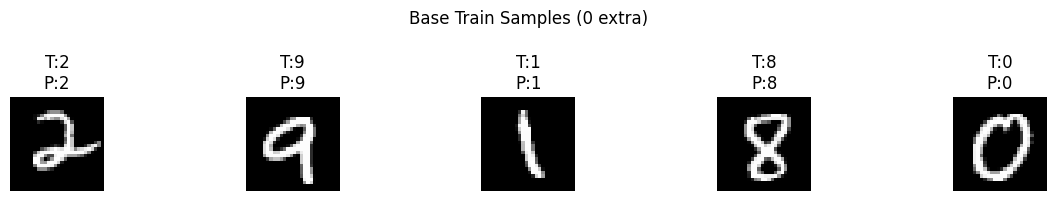

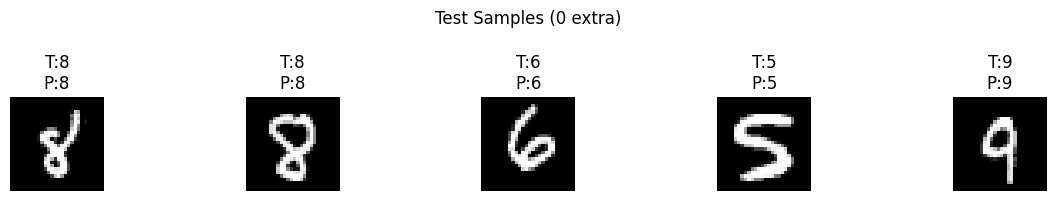

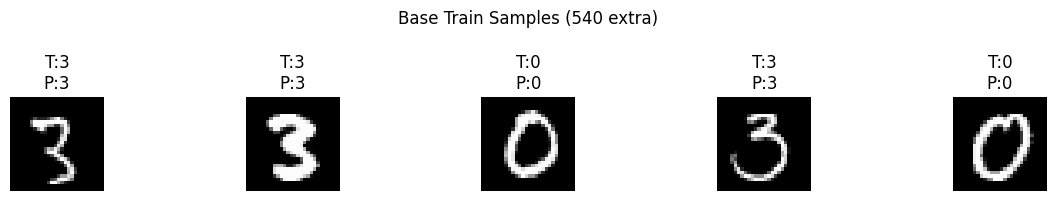

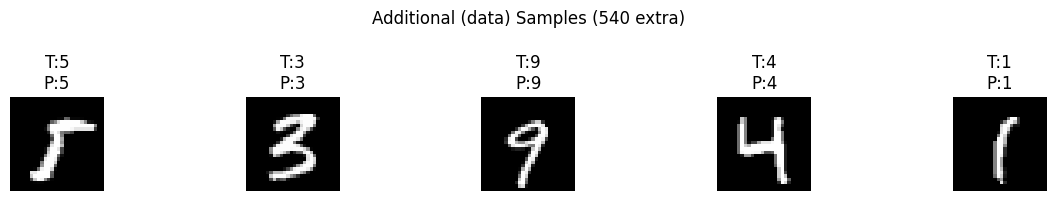

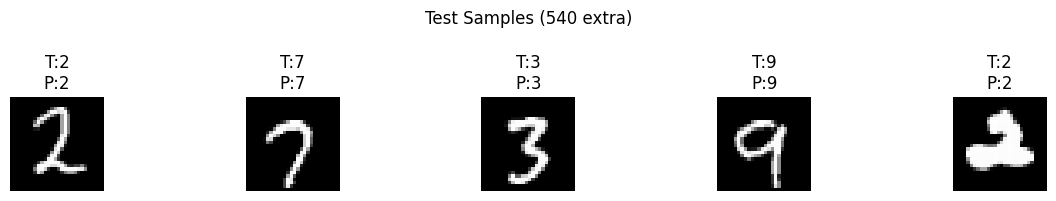

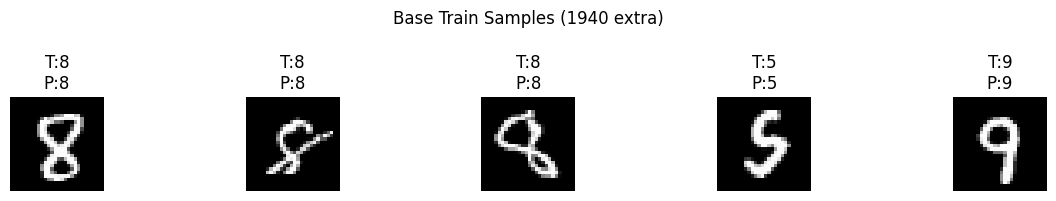

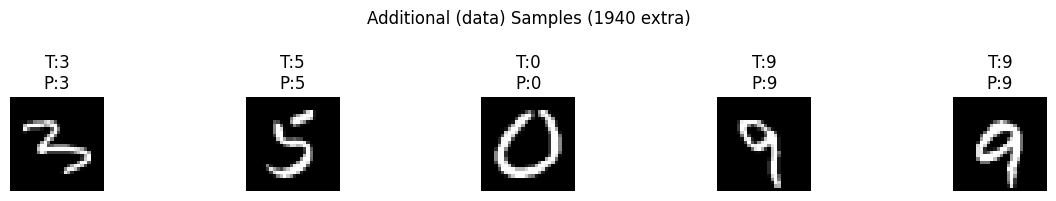

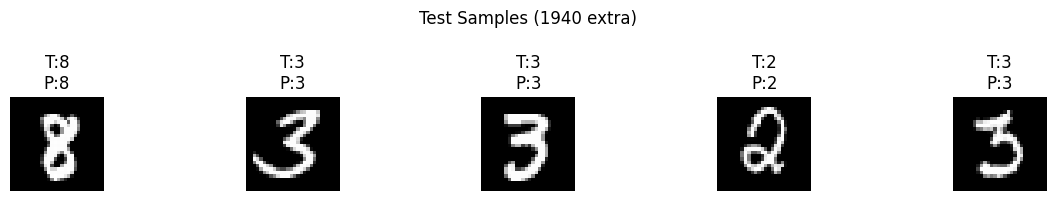

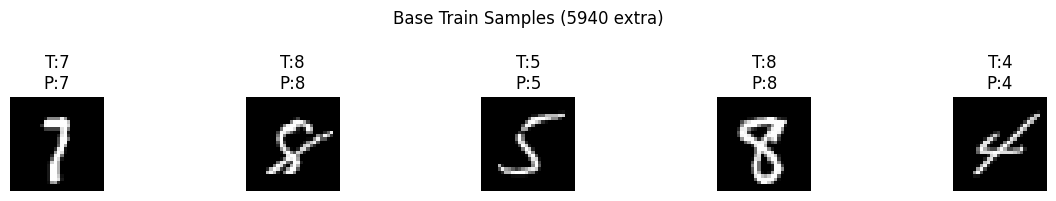

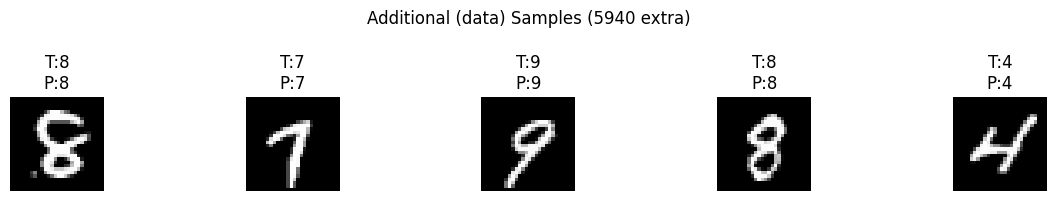

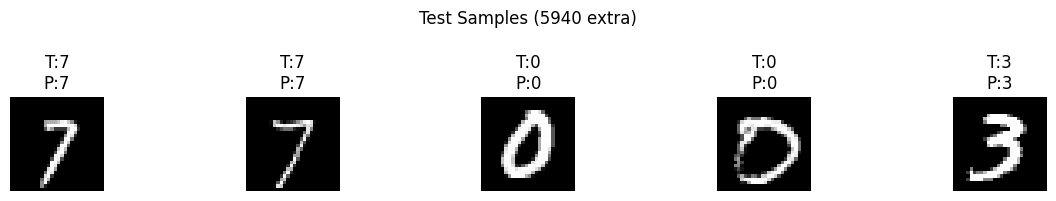

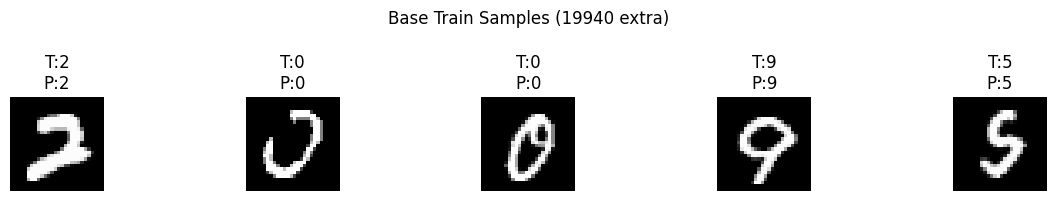

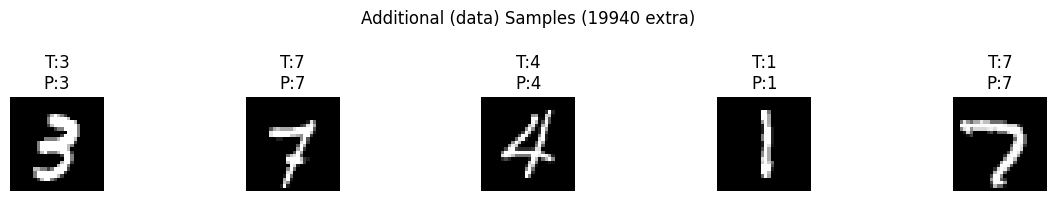

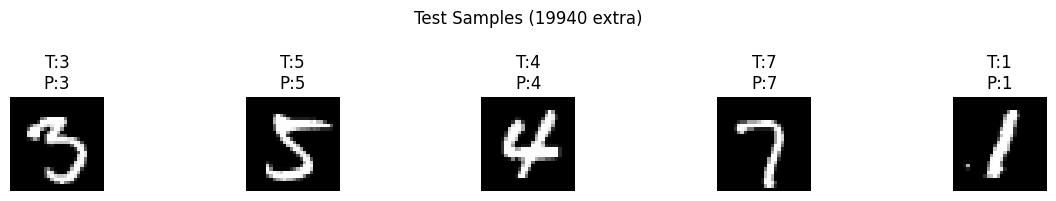

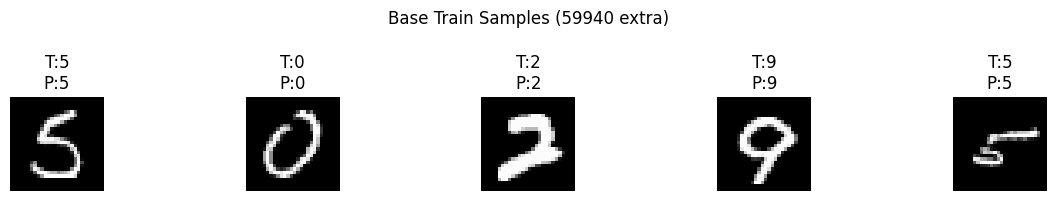

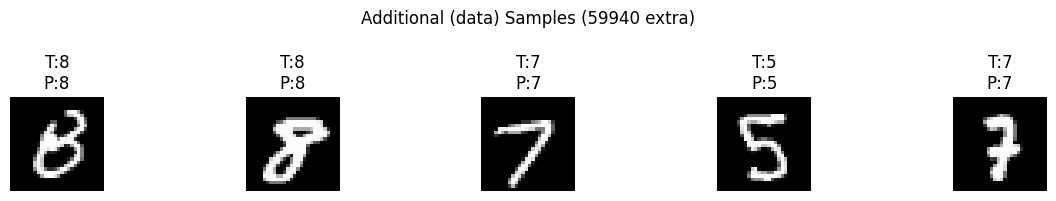

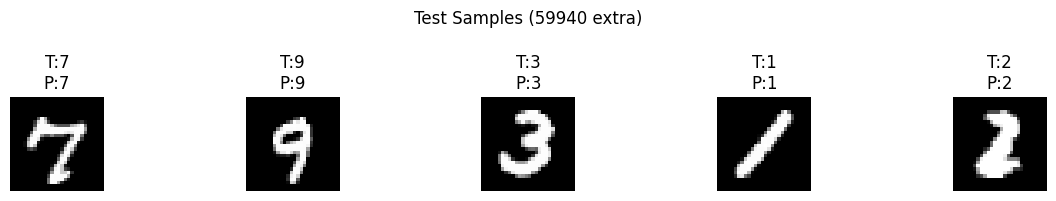

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_540.pt
Saved model: models_and_data/model_additional_540.pt
✅ Model saved to models_and_data\model_additional_1940.pt
Saved model: models_and_data/model_additional_1940.pt
✅ Model saved to models_and_data\model_additional_5940.pt
Saved model: models_and_data/model_additional_5940.pt
✅ Model saved to models_and_data\model_additional_19940.pt
Saved model: models_and_data/model_additional_19940.pt
✅ Model saved to models_and_data\model_additional_59940.pt
Saved model: models_and_data/model_additional_59940.pt
